In [3]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
import scipy.stats as st
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read in csv file
fire_data = '../Resources/California_Fire_Incidents.csv'
fire_data_df = pd.read_csv(fire_data)
fire_data_df.head()

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,Started,Time.1,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,8/17/13,15:25:00Z,Finalized,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN
1,30274.0,False,USFS Angeles National Forest/Los Angeles Count...,NaN,2013,True,/incidents/2013/5/30/powerhouse-fire/,NaN,NaN,Los Angeles,...,5/30/13,15:28:00Z,Finalized,NaN,NaN,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,2013-06-08T18:30:00Z,NaN
2,27531.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,NaN,2013,True,/incidents/2013/7/15/mountain-fire/,NaN,NaN,Riverside,...,7/15/13,13:43:00Z,Finalized,NaN,NaN,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,2013-07-30T18:00:00Z,NaN
3,27440.0,False,Tahoe National Forest,NaN,2013,False,/incidents/2013/8/10/american-fire/,NaN,NaN,Placer,...,8/10/13,16:30:00Z,Finalized,NaN,NaN,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,2013-08-30T08:00:00Z,NaN
4,24251.0,False,Ventura County Fire/CAL FIRE,NaN,2013,True,/incidents/2013/5/2/springs-fire/,Acreage has been reduced based upon more accur...,NaN,Ventura,...,5/2/13,07:01:00Z,Finalized,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,2013-05-11T06:30:00Z,11.0


In [5]:
# Clean data
ca_fire_df = fire_data_df.drop(columns=[
    "Active", 
    "CanonicalUrl", 
    "ConditionStatement", 
    "FuelType", 
    "Location", 
    "ControlStatement", 
    "CalFireIncident", 
    "AdminUnit", 
    "PercentContained", 
    "Time.1", 
    "Time", 
    "Status", 
    "SearchDescription", 
    "SearchKeywords", 
    "Public", 
    "Updated"], inplace=False)

# Store clean data in csv file
ca_fire_df.to_csv('../output_data/california_fire_cleaned.csv', index=False, header=True)

ca_fire_df.head()

,AcresBurned,AirTankers,ArchiveYear,Counties,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,MajorIncident,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders
0,257314.0,NaN,2013,Tuolumne,55,NaN,NaN,NaN,9/6/13,20,...,False,Rim Fire,NaN,8/17/13,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,NaN
1,30274.0,NaN,2013,Los Angeles,19,NaN,NaN,NaN,6/8/13,9,...,False,Powerhouse Fire,NaN,5/30/13,NaN,NaN,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,NaN
2,27531.0,NaN,2013,Riverside,33,NaN,NaN,NaN,7/30/13,15,...,False,Mountain Fire,NaN,7/15/13,NaN,NaN,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,NaN
3,27440.0,NaN,2013,Placer,31,NaN,NaN,NaN,8/30/13,20,...,False,American Fire,NaN,8/10/13,NaN,NaN,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,NaN
4,24251.0,NaN,2013,Ventura,56,47.0,8.0,117.0,5/11/13,9,...,True,Springs Fire,2167.0,5/2/13,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,11.0


In [28]:
# Focus on major fire incident
major_fire_df = ca_fire_df.loc[ca_fire_df['MajorIncident']==True]

major_fire_df.head()

,AcresBurned,AirTankers,ArchiveYear,Counties,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,MajorIncident,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders
4,24251.0,NaN,2013,Ventura,56,47.0,8.0,117.0,5/11/13,9,...,True,Springs Fire,2167.0,5/2/13,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,11.0
6,20292.0,NaN,2013,Riverside,33,63.0,20.0,201.0,8/12/13,5,...,True,Silver Fire,2106.0,8/7/13,8.0,40.0,NaN,NaN,c400203b-a7fd-4bd8-803a-f3c74bc32a2b,20.0
9,11429.0,NaN,2013,Tehama,52,30.0,3.0,36.0,8/29/13,6,...,True,Deer Fire,898.0,8/23/13,NaN,NaN,NaN,NaN,956dbcf6-db40-4b61-b235-4ede14738f1e,8.0
10,8073.0,NaN,2013,Shasta,45,12.0,3.0,30.0,9/15/13,6,...,True,Clover Fire,342.0,9/9/13,10.0,201.0,NaN,NaN,92af9783-eda9-4186-afe9-447f61a92636,NaN
11,7055.0,NaN,2013,San Diego,37,56.0,24.0,183.0,7/15/13,9,...,True,Chariot Fire,2147.0,7/6/13,9.0,149.0,NaN,NaN,ee19b2ec-a96a-4738-994e-fb3ea016e053,24.0


### Correlation between final size burned (acres) vs time burned (days)

In [36]:
final_burned = major_fire_df.groupby('UniqueId').first()[['Days Burned', 'AcresBurned', 'Dozers']]
final_burned_df = final_burned.reset_index()
final_burned_df

,UniqueId,Days Burned,AcresBurned
0,00089805-cdee-4607-8b67-1653bee463bc,4,1469.0
1,020310d3-7834-4f57-a125-eff0eb3f54e5,-43762,4615.0
2,02d470c1-bf41-4ff9-9424-f680cef5bbbc,5,215.0
3,040d03d0-fbdd-438c-8174-f81e4a1bba57,24,46344.0
4,04b54dc3-10a2-4fdf-bfa6-60a1fe2b0f7d,182,400.0
...,...,...,...
356,fe668595-0980-4f41-af0c-3f14c4d391c2,5,114.0
357,fef2ab8a-20d7-4dc3-b5c9-363aa1debef3,4,210.0
358,ffb3293b-3349-49c5-a7cb-c488391e8a72,27,7474.0
359,ffbc1cb8-be33-4483-8442-85ab2587dce4,1,110.0


In [37]:
# Calculate the IQR and quantitatively determine if there are any potential outliers.
days = final_burned_df.loc[final_burned_df['Days Burned']>=0, 'Days Burned']
area = final_burned_df.loc[final_burned_df['Days Burned']>=0, 'AcresBurned']

# Calculate the IQR and quantitatively
area_quartiles = area.quantile([0.25,0.5,0.75])
area_lowerq = area_quartiles[0.25]
area_upperq = area_quartiles[0.75]
area_mean = area.mean()
area_iqr = area_upperq-area_lowerq    
area_lower_bound = area_lowerq - (1.5*area_iqr)
area_upper_bound = area_upperq + (1.5*area_iqr)

# Determine outliers using upper and lower bounds
area_outliers = area.loc[(area < area_lower_bound) | (area > area_upper_bound)]

# Print out the result
print(f"Final burned area (arces) below {round(area_lower_bound,2)} could be outliers.")
print(f"Final burned area (arces) above {round(area_upper_bound,2)} could be outliers.")
print(f"Average final burned area (arces) is: {round(area_mean,2)}")
print(f"Number of outliers is: {area_outliers.count()}")

Final burned area (arces) below -3123.25 could be outliers.
Final burned area (arces) above 5418.75 could be outliers.
Average final burned area (arces) is: 7917.84
Number of outliers is: 57


The correlation between burned area (acres) and burned days is -0.0
The r-squared is: 0.0


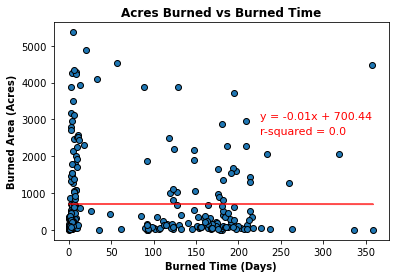

In [38]:
# Define x,y values
area_x_values = days.drop(area_outliers.index)
area_y_values = area.drop(area_outliers.index)

# Calculate the correlation
area_correlation = round(st.pearsonr(area_x_values, area_y_values)[0],2)
print(f"The correlation between burned area (acres) and burned days is {area_correlation}")

# Calculate linear regression values
(area_slope, area_intercept, area_rvalue, area_pvalue, area_stderr) = st.linregress(area_x_values, area_y_values)

# Calculate r-squared
area_r_squared = round(area_rvalue**2,2)
print(f"The r-squared is: {area_r_squared}")

# y = mx + b
area_regress_values = area_x_values * area_slope + area_intercept
area_line_eq = "y = " + str(round(area_slope,2)) + "x + " + str(round(area_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(area_x_values, area_y_values, edgecolors='black')
plt.plot(area_x_values,area_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(area_line_eq,(225,3000), fontsize=11, color="red")
plt.annotate(f'r-squared = {area_r_squared}', (225,2600), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Burned Time', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Burned Area (Acres)', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/day_area.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

### Correlation between resources vs final size burned

In [35]:
# Define x,y values
per_inv_x_values = per_inv.drop(area_outliers.index)

# Calculate the correlation
per_inv_correlation = round(st.pearsonr(per_inv_x_values, area_y_values)[0],2)
print(f"The correlation between burned area (acres) and burned days is {per_inv_correlation}")

# Calculate linear regression values
(per_inv_slope, per_inv_intercept, per_inv_rvalue, per_inv_pvalue, per_inv_stderr) = st.linregress(per_inv_x_values, 
                                                                                                   area_y_values)

# Calculate r-squared
per_inv_r_squared = round(per_inv_rvalue**2,2)
print(f"The r-squared is: {per_inv_r_squared}")

# y = mx + b
per_inv_regress_values = per_inv_x_values * per_inv_slope + per_inv_intercept
per_inv_line_eq = "y = " + str(round(per_inv_slope,2)) + "x + " + str(round(per_inv_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(per_inv_x_values, area_y_values, edgecolors='black')
plt.plot(per_inv_x_values,per_inv_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(per_inv_line_eq,(225,7000), fontsize=11, color="red")
plt.annotate(f'r-squared = {per_inv_r_squared}', (225,6500), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Personnel Involved', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Personnel Involved', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/day_perinv.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

KeyError: '[  3  24  26  34  47  58  89  90  92  98 112 118 125 134 139 141 154 161\n 169 175 179 210 211 213 216 219 221 231 235 247 249 264 266 269 271 278\n 285 324 328 330 358] not found in axis'